# Week 8 Seminar Answers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
import yfinance as yf
import os

## Question 1

In [2]:
data = yf.download('SPY', start='2022-11-03', end='2023-11-03')

[*********************100%%**********************]  1 of 1 completed


In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-11-03,371.470001,374.200012,368.790009,371.010010,365.260010,87100100
2022-11-04,377.000000,378.869995,370.000000,376.350006,370.517212,103505200
2022-11-07,377.709991,380.570007,375.529999,379.950012,374.061462,68286900
2022-11-08,381.109985,385.119995,377.720001,382.000000,376.079681,84641100
2022-11-09,379.929993,381.140015,373.609985,374.130005,368.331635,78495500


In [4]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-10-27,414.190002,414.600006,409.209991,410.679993,410.679993,107367700
2023-10-30,413.559998,416.679993,412.220001,415.589996,415.589996,86562700
2023-10-31,416.179993,418.529999,414.209991,418.200012,418.200012,79665200
2023-11-01,419.200012,423.500000,418.649994,422.660004,422.660004,98068100
2023-11-02,426.579987,430.920013,426.559998,430.760010,430.760010,94938900


In [5]:
S = data['Adj Close'][-1]
print('The spot price is', round(S,2))

The spot price is 430.76


## Question 2 

Step 1: Find the log return of Index

In [6]:
log_return = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

Step 2: Calculate its standard deviation and annualised  it 

In [7]:
vol = np.sqrt(252) * log_return.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 15.41 %


And the spot value for VIX is 

In [8]:
VIX = yf.download("^VIX", start="2022-11-03", end="2023-11-03")

[*********************100%%**********************]  1 of 1 completed


In [9]:
vix = VIX['Adj Close'][-1]
print('The market volatility is', round(vix,2), '%')

The market volatility is 15.66 %


## Question 3

In [10]:
def euro_option_bs(S, K, T, r, vol, payoff):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #vol: volatility of underlying asset
    #payoff: call or put
    
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [11]:
K = 400
T = 36/252    #36 trading days from 02/11/2023 to 22/12/2023 
r = 0.0382

In [12]:
call = euro_option_bs(S, K, T, r, vol, 'call')
print('The BS call price is', round(call, 2))

The BS call price is 33.89


In [13]:
put = euro_option_bs(S, K, T, r, vol, 'put')
print('The BS put price is', round(put, 2))

The BS put price is 0.95


## Question 4

In [14]:
SP500 = yf.Ticker('SPY')

In [15]:
opt = SP500.option_chain('2023-12-22')
call1 = opt.calls.lastPrice[opt.calls.strike == K]
print('The Market call price is', float(call1.values))

The Market call price is 52.03


In [16]:
put1 = opt.puts.lastPrice[opt.puts.strike == K]
print('The Market put price is', float(put1.values))

The Market put price is 0.46


## Question 5

In [17]:
call2 = euro_option_bs(S, K, T, r, vix*0.01, 'call')
print('The BS call price is', round(call2,2))

The BS call price is 33.95


In [18]:
put2 = euro_option_bs(S, K, T, r, vix*0.01, 'put')
print('The BS put price is', round(put2,2))

The BS put price is 1.02


The results using the VIX is almost identical to the results using the historical standard deviation. This is because the VIX value and the historical standard deviation are very close.

## Question 6

In [19]:
K = np.linspace(375,425,6)
T = [1/52, 2/52, 1/12, 2/12, 1/4, 1/2, 1]

In [20]:
call = np.zeros((len(T),len(K)))
for i in range(len(T)):
    for j in range(len(K)):
        call[i,j] = euro_option_bs(S, K[j], T[i], r, vix*0.01, 'call')

In [21]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

strike, ttm = np.meshgrid(K, T)

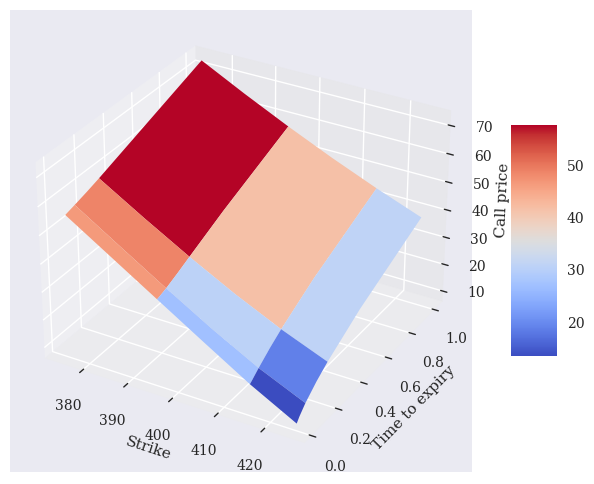

In [22]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(strike, ttm, call, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Strike')
ax.set_ylabel('Time to expiry')
ax.set_zlabel('Call price')
fig.colorbar(surf, shrink=0.5, aspect=5);